In [1]:
import sys
from pathlib import Path
import numpy as np
from PIL import Image
from dotenv import load_dotenv
import pandas as pd
from inference_sdk import InferenceHTTPClient
from PIL import Image, ImageEnhance
from IPython.display import clear_output
import os
import numpy as np

# 🔎 Busquem la carpeta arrel del projecte: "potato-dry-matter-optics-ml"
current_path = Path().resolve()
TARGET_ROOT_NAME = "potato-dry-matter-optics-ml"

while current_path.name != TARGET_ROOT_NAME and current_path.parent != current_path:
    current_path = current_path.parent

if current_path.name != TARGET_ROOT_NAME:
    raise RuntimeError(
        f"No s'ha trobat la carpeta '{TARGET_ROOT_NAME}' pujant des del directori actual: {Path().resolve()}"
    )

project_root = current_path
sys.path.append(str(project_root))

# Cargar variables de entorno (ROBOFLOW_API_KEY)
load_dotenv()

# Import del mètode a testejar
from src.raw_image_treatment import potato_defect_classification, potato_pixels_rgb_img, apply_brightness_and_gamma

print(f"✅ Project root: {project_root}")


✅ Project root: C:\Users\david\Desktop\Uni\potato-dry-matter-optics-ml


In [2]:
# Carpeta d'imatges
img_dir = project_root / "data/input/raw/raw_images/test_1"

# Llistat d'imatges del lot 1
paths = []
paths += [img_dir / f"p1_{i}.png" for i in range(1, 25)]
paths += [img_dir / f"p2_{j}.png" for j in range(1, 12)]

In [3]:
rows = []
thr = 0.0
total = len(paths)

for k, p in enumerate(paths, start=1):
    clear_output(wait=True)
    print(f"⏳ Processant patata {k}/{total}: {p.name}")

    if not p.exists():
        rows.append({
            "filename": p.name,
            "path": str(p),
            "defect": "Unable to classify",
            "confidence": 0.0,
            "n_predictions": 0,
            "status": "missing_file",
        })
        continue

    # 1) Defecte + confidence + imatge anotada (tot ve de la funció millorada)
    defect, conf, _vis = potato_defect_classification(p, confidence_threshold=thr)

    # 2) Metadades coherents amb el nou output (sense tornar a cridar Roboflow aquí)
    if defect == "Unable to classify":
        n_preds = 0
        status = "no_predictions"
    else:
        n_preds = 1
        status = "ok"

    rows.append({
        "filename": p.name,
        "defect": defect,
        "confidence": conf,
        "n_predictions": n_preds,
        "status": status,
    })

clear_output(wait=True)
print(f"✅ Completat: {total}/{total} imatges processades.")

df = pd.DataFrame(rows)

# Ordenar: primer p1_*, després p2_*
def _sort_key(name: str):
    stem = Path(name).stem  # p1_10
    part, idx = stem.split("_")
    lot = int(part[1:])     # 1 o 2
    return (lot, int(idx))

df = df.sort_values("filename", key=lambda s: s.map(_sort_key)).reset_index(drop=True)

df

✅ Completat: 35/35 imatges processades.


,filename,defect,confidence,n_predictions,status
0,p1_1.png,Damaged potato,0.527929,1,ok
1,p1_2.png,Potato,0.411502,1,ok
2,p1_3.png,Damaged potato,0.689305,1,ok
3,p1_4.png,Damaged potato,0.582804,1,ok
4,p1_5.png,Damaged potato,0.764448,1,ok
5,p1_6.png,Diseased-fungal potato,0.554523,1,ok
6,p1_7.png,Damaged potato,0.679146,1,ok
7,p1_8.png,Potato,0.615870,1,ok
8,p1_9.png,Damaged potato,0.588562,1,ok
9,p1_10.png,Damaged potato,0.485205,1,ok


In [ ]:
rows_bright = []
thr = 0.0
total = len(paths)

for k, p in enumerate(paths, start=1):
    clear_output(wait=True)
    print(f"💡 (Brightness x1.5) Processant patata {k}/{total}: {p.name}")

    if not p.exists():
        rows_bright.append({
            "filename": p.name,
            "defect": "Unable to classify",
            "confidence": 0.0,
            "status": "missing_file",
        })
        continue

    # Carregar imatge i augmentar brightness
    pil = Image.open(p).convert("RGB")
    pil_bright = ImageEnhance.Brightness(pil).enhance(1.5)

    # Classificació (sense tornar a cridar Roboflow aquí)
    defect, conf, _vis = potato_defect_classification(pil_bright, confidence_threshold=thr)

    status = "ok" if defect != "Unable to classify" else "no_predictions"

    rows_bright.append({
        "filename": p.name,
        "defect": defect,
        "confidence": conf,
        "status": status,
    })

clear_output(wait=True)
print("✅ Brightness x1.5 completat")

df_bright = pd.DataFrame(rows_bright)
df_bright

In [ ]:
rows_cropped = []
thr = 0.0
total = len(paths)

for k, p in enumerate(paths, start=1):
    clear_output(wait=True)
    print(f"✂️ (Cropped→Defect) Processant patata {k}/{total}: {p.name}")

    if not p.exists():
        rows_cropped.append({
            "filename": p.name,
            "defect": "Unable to classify",
            "confidence": 0.0,
            "status": "missing_file",
        })
        continue

    # 1) Obtenir cropped_img (segmentació)
    cropped_img, _vis = potato_pixels_rgb_img(p, margin=50)

    if cropped_img is None:
        rows_cropped.append({
            "filename": p.name,
            "defect": "Unable to classify",
            "confidence": 0.0,
            "status": "no_mask",
        })
        continue

    # 2) Predicció de defecte sobre el cropped (sense cridar Roboflow aquí)
    defect, conf, _vis_def = potato_defect_classification(cropped_img, confidence_threshold=thr)
    status = "ok" if defect != "Unable to classify" else "no_predictions"

    rows_cropped.append({
        "filename": p.name,
        "defect": defect,
        "confidence": conf,
        "status": status,
    })

clear_output(wait=True)
print("✅ Cropped→Defect completat")

df_cropped = pd.DataFrame(rows_cropped)
df_cropped

In [ ]:
rows_cropped_m50 = []
thr = 0.0
total = len(paths)

for k, p in enumerate(paths, start=1):
    clear_output(wait=True)
    print(f"✂️ (Cropped m=50 → Defect) Processant patata {k}/{total}: {p.name}")

    if not p.exists():
        rows_cropped_m50.append({
            "filename": p.name,
            "defect": "Unable to classify",
            "confidence": 0.0,
            "status": "missing_file",
        })
        continue

    # 1) Obtenir cropped_img (segmentació) amb margin=50
    cropped_img, _vis = potato_pixels_rgb_img(p, margin=50)

    if cropped_img is None:
        rows_cropped_m50.append({
            "filename": p.name,
            "defect": "Unable to classify",
            "confidence": 0.0,
            "status": "no_mask",
        })
        continue

    # 2) Predicció de defecte sobre el cropped (sense cridar Roboflow aquí)
    defect, conf, _vis_def = potato_defect_classification(cropped_img, confidence_threshold=thr)
    status = "ok" if defect != "Unable to classify" else "no_predictions"

    rows_cropped_m50.append({
        "filename": p.name,
        "defect": defect,
        "confidence": conf,
        "status": status,
    })

clear_output(wait=True)
print("✅ Cropped(margin=50) → Defect completat")

df_cropped_m50 = pd.DataFrame(rows_cropped_m50)
df_cropped_m50

In [ ]:
rows_cropped_m50_bright = []
thr = 0.0
total = len(paths)

for k, p in enumerate(paths, start=1):
    clear_output(wait=True)
    print(f"✂️💡 (Cropped m=50 + Brightness x1.5) {k}/{total}: {p.name}")

    if not p.exists():
        rows_cropped_m50_bright.append({
            "filename": p.name,
            "defect": "Unable to classify",
            "confidence": 0.0,
            "status": "missing_file",
        })
        continue

    # 1) Cropped amb margin=50
    cropped_img, _vis = potato_pixels_rgb_img(p, margin=50)

    if cropped_img is None:
        rows_cropped_m50_bright.append({
            "filename": p.name,
            "defect": "Unable to classify",
            "confidence": 0.0,
            "status": "no_mask",
        })
        continue

    # 2) Brightness x1.5 sobre el cropped
    cropped_bright = ImageEnhance.Brightness(cropped_img).enhance(1.5)

    # 3) Predicció defecte + confidence (sense cridar Roboflow aquí)
    defect, conf, _vis_def = potato_defect_classification(cropped_bright, confidence_threshold=thr)
    status = "ok" if defect != "Unable to classify" else "no_predictions"

    rows_cropped_m50_bright.append({
        "filename": p.name,
        "defect": defect,
        "confidence": conf,
        "status": status,
    })

clear_output(wait=True)
print("✅ Cropped(m=50) + Brightness x1.5 → Defect completat")

df_cropped_m50_bright = pd.DataFrame(rows_cropped_m50_bright)
df_cropped_m50_bright

In [ ]:
# Roboflow client
ROBOFLOW_MODEL_ID = "potato-detection-3et6q/11"
api_key = os.environ["ROBOFLOW_API_KEY"]
client = InferenceHTTPClient(api_url="https://serverless.roboflow.com", api_key=api_key)

rows_bright15 = []
thr = 0.0
total = len(paths)

for k, p in enumerate(paths, start=1):
    clear_output(wait=True)
    print(f"💡 (Brightness x2.0) Processant patata {k}/{total}: {p.name}")

    if not p.exists():
        rows_bright15.append({
            "filename": p.name,
            "defect": np.nan,
            "confidence": np.nan,
            "status": "missing_file",
        })
        continue

    # 1) Carregar imatge i aplicar brightness x2.0
    pil = Image.open(p).convert("RGB")
    pil_bright2 = ImageEnhance.Brightness(pil).enhance(2.0)

    # 2) Inferència directa
    result = client.infer(pil_bright2, model_id=ROBOFLOW_MODEL_ID)
    preds = result.get("predictions", [])

    if preds:
        best = max(preds, key=lambda d: float(d.get("confidence", 0.0)))
        defect = best.get("class")
        conf = float(best.get("confidence", 0.0))
        status = "ok"
    else:
        defect = np.nan
        conf = np.nan
        status = "no_predictions"

    rows_bright2.append({
        "filename": p.name,
        "defect": defect,
        "confidence": conf,
        "status": status,
    })

clear_output(wait=True)
print("✅ Brightness x2.0 completat")

df_bright2 = pd.DataFrame(rows_bright2)
df_bright2

In [ ]:
rows_bright25 = []
thr = 0.0
total = len(paths)

for k, p in enumerate(paths, start=1):
    clear_output(wait=True)
    print(f"💡 (Brightness x2.5) Processant patata {k}/{total}: {p.name}")

    if not p.exists():
        rows_bright25.append({
            "filename": p.name,
            "defect": "Unable to classify",
            "confidence": 0.0,
            "status": "missing_file",
        })
        continue

    pil = Image.open(p).convert("RGB")
    pil_bright25 = ImageEnhance.Brightness(pil).enhance(2.5)

    defect, conf, _vis = potato_defect_classification(pil_bright25, confidence_threshold=thr)
    status = "ok" if defect != "Unable to classify" else "no_predictions"

    rows_bright25.append({
        "filename": p.name,
        "defect": defect,
        "confidence": conf,
        "status": status,
    })

clear_output(wait=True)
print("✅ Brightness x2.5 completat")

df_bright25 = pd.DataFrame(rows_bright25)
df_bright25

In [3]:
# --- Gamma correction helper ---------------------------------------
def gamma_correction(pil_img, gamma=0.8):
    arr = np.asarray(pil_img).astype(np.float32) / 255.0
    arr = arr ** gamma
    arr = np.clip(arr * 255.0, 0, 255).astype(np.uint8)
    return Image.fromarray(arr)

rows_bright2_gamma = []
thr = 0.0
total = len(paths)

for k, p in enumerate(paths, start=1):
    clear_output(wait=True)
    print(f"💡🌗 (Brightness x2 + Gamma 0.8) {k}/{total}: {p.name}")

    if not p.exists():
        rows_bright2_gamma.append({
            "filename": p.name,
            "defect": "Unable to classify",
            "confidence": 0.0,
            "status": "missing_file",
        })
        continue

    # 1) Load image
    pil = Image.open(p).convert("RGB")

    # 2) Brightness x2
    pil_b2 = ImageEnhance.Brightness(pil).enhance(2.0)

    # 3) Gamma correction
    pil_b2_gamma = gamma_correction(pil_b2, gamma=0.8)

    # 4) Classificació (sense cridar Roboflow aquí)
    defect, conf, _vis = potato_defect_classification(pil_b2_gamma, confidence_threshold=thr)
    status = "ok" if defect != "Unable to classify" else "no_predictions"

    rows_bright2_gamma.append({
        "filename": p.name,
        "defect": defect,
        "confidence": conf,
        "status": status,
    })

clear_output(wait=True)
print("✅ Brightness x2 + Gamma (γ=0.8) completat")

df_bright2_gamma = pd.DataFrame(rows_bright2_gamma)
df_bright2_gamma

✅ Brightness x2 + Gamma (γ=0.8) completat


,filename,defect,confidence,status
0,p1_1.png,Potato,0.937543,ok
1,p1_2.png,Potato,0.870144,ok
2,p1_3.png,Potato,0.818213,ok
3,p1_4.png,Potato,0.866222,ok
4,p1_5.png,Potato,0.864748,ok
5,p1_6.png,Potato,0.919829,ok
6,p1_7.png,Damaged potato,0.788147,ok
7,p1_8.png,Potato,0.881276,ok
8,p1_9.png,Potato,0.899187,ok
9,p1_10.png,Potato,0.752340,ok


In [ ]:
# --- Gamma correction helper ---------------------------------------
def gamma_correction(pil_img, gamma=0.8):
    arr = np.asarray(pil_img).astype(np.float32) / 255.0
    arr = arr ** gamma
    arr = np.clip(arr * 255.0, 0, 255).astype(np.uint8)
    return Image.fromarray(arr)

rows_bright25_gamma = []
thr = 0.0
total = len(paths)

for k, p in enumerate(paths, start=1):
    clear_output(wait=True)
    print(f"💡🌗 (Brightness x2.5 + Gamma 0.8) {k}/{total}: {p.name}")

    if not p.exists():
        rows_bright25_gamma.append({
            "filename": p.name,
            "defect": "Unable to classify",
            "confidence": 0.0,
            "status": "missing_file",
        })
        continue

    # 1) Load image
    pil = Image.open(p).convert("RGB")

    # 2) Brightness x2.5
    pil_b25 = ImageEnhance.Brightness(pil).enhance(2.5)

    # 3) Gamma correction
    pil_b25_gamma = gamma_correction(pil_b25, gamma=0.8)

    # 4) Classificació (sense cridar Roboflow aquí)
    defect, conf, _vis = potato_defect_classification(pil_b25_gamma, confidence_threshold=thr)
    status = "ok" if defect != "Unable to classify" else "no_predictions"

    rows_bright25_gamma.append({
        "filename": p.name,
        "defect": defect,
        "confidence": conf,
        "status": status,
    })

clear_output(wait=True)
print("✅ Brightness x2.5 + Gamma (γ=0.8) completat")

df_bright25_gamma = pd.DataFrame(rows_bright25_gamma)
df_bright25_gamma

In [4]:
rows_cropped_m50_bright2_gamma = []
thr = 0.0
total = len(paths)

for k, p in enumerate(paths, start=1):
    clear_output(wait=True)
    print(f"✂️💡🌗 (Cropped m=50 + Brightness x2 + Gamma 0.8) {k}/{total}: {p.name}")

    if not p.exists():
        rows_cropped_m50_bright2_gamma.append({
            "filename": p.name,
            "defect": "Unable to classify",
            "confidence": 0.0,
            "status": "missing_file",
        })
        continue

    # 1) Cropped amb margin=50
    cropped_img, _vis_crop = potato_pixels_rgb_img(p, margin=50)

    if cropped_img is None:
        rows_cropped_m50_bright2_gamma.append({
            "filename": p.name,
            "defect": "Unable to classify",
            "confidence": 0.0,
            "status": "no_mask",
        })
        continue

    # 2) Aplicar Brightness + Gamma amb la funció del src
    img_proc = apply_brightness_and_gamma(cropped_img, brightness=2.0, gamma=0.8)

    # 3) Classificació (sense cridar Roboflow aquí)
    defect, conf, _vis = potato_defect_classification(img_proc, confidence_threshold=thr)
    status = "ok" if defect != "Unable to classify" else "no_predictions"

    rows_cropped_m50_bright2_gamma.append({
        "filename": p.name,
        "defect": defect,
        "confidence": conf,
        "status": status,
    })

clear_output(wait=True)
print("✅ Cropped(m=50) + Brightness x2 + Gamma (γ=0.8) completat")

df_cropped_m50_bright2_gamma = pd.DataFrame(rows_cropped_m50_bright2_gamma)
df_cropped_m50_bright2_gamma


✅ Cropped(m=50) + Brightness x2 + Gamma (γ=0.8) completat


,filename,defect,confidence,status
0,p1_1.png,Potato,0.756609,ok
1,p1_2.png,Potato,0.865730,ok
2,p1_3.png,Potato,0.854923,ok
3,p1_4.png,Potato,0.582329,ok
4,p1_5.png,Potato,0.851907,ok
5,p1_6.png,Potato,0.905411,ok
6,p1_7.png,Diseased-fungal potato,0.433521,ok
7,p1_8.png,Potato,0.543830,ok
8,p1_9.png,Potato,0.824928,ok
9,p1_10.png,Potato,0.866311,ok


In [ ]:
rows_cropped_m35_bright15_gamma = []
thr = 0.0
total = len(paths)

for k, p in enumerate(paths, start=1):
    clear_output(wait=True)
    print(f"✂️💡🌗 (Cropped m=35 + Brightness x1.5 + Gamma 0.8) {k}/{total}: {p.name}")

    if not p.exists():
        rows_cropped_m35_bright15_gamma.append({
            "filename": p.name,
            "defect": "Unable to classify",
            "confidence": 0.0,
            "status": "missing_file",
        })
        continue

    # 1) Cropped amb margin=35
    cropped_img, _vis_crop = potato_pixels_rgb_img(p, margin=35)

    if cropped_img is None:
        rows_cropped_m35_bright15_gamma.append({
            "filename": p.name,
            "defect": "Unable to classify",
            "confidence": 0.0,
            "status": "no_mask",
        })
        continue

    # 2) Aplicar Brightness + Gamma amb la funció del src
    img_proc = apply_brightness_and_gamma(cropped_img, brightness=1.5, gamma=0.8)

    # 3) Classificació (sense cridar Roboflow aquí)
    defect, conf, _vis = potato_defect_classification(img_proc, confidence_threshold=thr)
    status = "ok" if defect != "Unable to classify" else "no_predictions"

    rows_cropped_m35_bright15_gamma.append({
        "filename": p.name,
        "defect": defect,
        "confidence": conf,
        "status": status,
    })

clear_output(wait=True)
print("✅ Cropped(m=35) + Brightness x1.5 + Gamma (γ=0.8) completat")

df_cropped_m35_bright15_gamma = pd.DataFrame(rows_cropped_m35_bright15_gamma)
df_cropped_m35_bright15_gamma


✅ Cropped(m=35) + Brightness x2 + Gamma (γ=0.8) completat


,filename,defect,confidence,status
0,p1_1.png,Potato,0.834415,ok
1,p1_2.png,Potato,0.884247,ok
2,p1_3.png,Potato,0.724986,ok
3,p1_4.png,Potato,0.551903,ok
4,p1_5.png,Potato,0.782219,ok
5,p1_6.png,Potato,0.856086,ok
6,p1_7.png,Diseased-fungal potato,0.406331,ok
7,p1_8.png,Potato,0.598575,ok
8,p1_9.png,Potato,0.806792,ok
9,p1_10.png,Potato,0.831382,ok


🧪 Defect classification:
   • Classe     : Potato
   • Confidence : 0.859


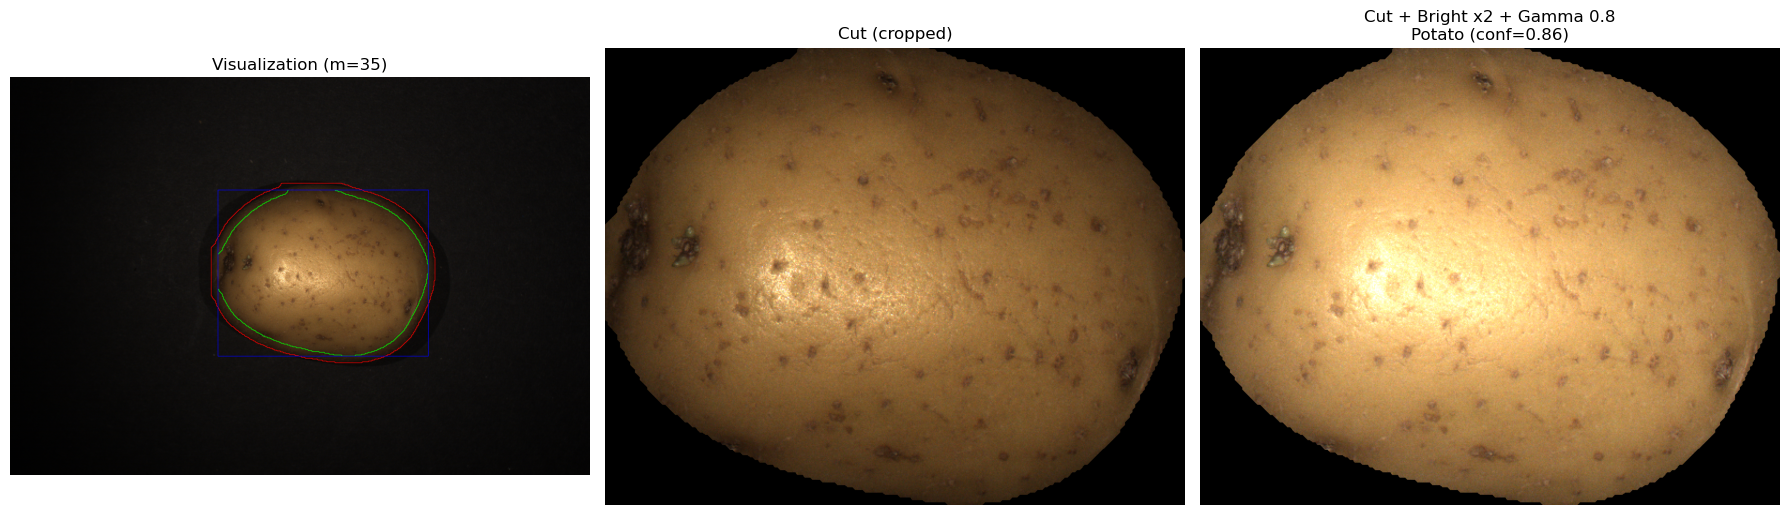

In [6]:
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------------------------------------------------
# Config
# ------------------------------------------------------------
IMG_PATH = project_root / "data/input/raw/raw_images/test_1/p1_21.png"
MARGIN = 35
CONF_THR = 0.0   # no filtrem aquí, només test

assert IMG_PATH.exists(), f"No existeix: {IMG_PATH.resolve()}"

# ------------------------------------------------------------
# 1) Roboflow segmentation (vis + crop)
# ------------------------------------------------------------
cropped_img, vis_img = potato_pixels_rgb_img(
    IMG_PATH,
    margin=MARGIN,
)

if cropped_img is None:
    print("⚠️ No s'ha obtingut màscara / crop")
    plt.figure(figsize=(8, 6))
    plt.imshow(vis_img)
    plt.title("Visualization (no crop)")
    plt.axis("off")
    plt.show()

else:
    # ------------------------------------------------------------
    # 2) Brightness x2 + Gamma 0.8
    # ------------------------------------------------------------
    proc_img = apply_brightness_and_gamma(
        cropped_img,
        brightness=1.5,
        gamma=0.8
    )

    # ------------------------------------------------------------
    # 3) Defect classification (SENSE Roboflow aquí)
    # ------------------------------------------------------------
    defect, conf, vis_cls = potato_defect_classification(
        proc_img,
        confidence_threshold=CONF_THR
    )

    print(f"🧪 Defect classification:")
    print(f"   • Classe     : {defect}")
    print(f"   • Confidence : {conf:.3f}")

    # ------------------------------------------------------------
    # 4) Plot final
    # ------------------------------------------------------------
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(vis_img)
    axes[0].set_title(f"Visualization (m={MARGIN})")
    axes[0].axis("off")

    axes[1].imshow(cropped_img)
    axes[1].set_title("Cut (cropped)")
    axes[1].axis("off")

    axes[2].imshow(proc_img)
    axes[2].set_title(
        f"Cut + Bright x2 + Gamma 0.8\n"
        f"{defect} (conf={conf:.2f})"
    )
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
def summarize(df, label):
    total = len(df)

    summary = (
        df.dropna(subset=["defect"])
        .groupby("defect")
        .agg(
            detections=("defect", "count"),
            mean_confidence=("confidence", "mean"),
        )
        .reset_index()
    )

    summary["% deteccio"] = 100 * summary["detections"] / total
    summary["mean_confidence_%"] = 100 * summary["mean_confidence"]
    summary["case"] = label

    return summary[["case", "defect", "% deteccio", "mean_confidence_%"]]


summary_all = pd.concat(
    [
        summarize(df, "original"),
        summarize(df_bright, "brightness_x1.5"),
        summarize(df_bright2, "brightness_x2.0"),
        summarize(df_bright25, "brightness_x2.5"),
        summarize(df_bright2_gamma, "brightness_x2_gamma"),
        summarize(df_bright25_gamma, "brightness_x2.5_gamma"),
        summarize(df_cropped, "cropped_then_defect_m0"),
        summarize(df_cropped_m50, "cropped_then_defect_m50"),
        summarize(df_cropped_m50_bright2_gamma, "cropped_m50_brightness_x2_gamma"),
    ],
    ignore_index=True
)

summary_all.sort_values(
    ["case", "% deteccio"],
    ascending=[True, False]
)